In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import display
from pathlib import Path
from PIL import Image
import os

# set current path to $HOME/Projects/ocean-relic/
current_path = Path(os.path.expandvars('$HOME/Projects/ocean-relic/'))

Index: 0 - [t1 -> b2 (yellow), l2 -> t0 (pink)]
Index: 1 - [b2 -> r1 (pink), r1 -> b0 (orange), l0 -> t2 (yellow)]
Index: 2 - [r0 -> l1 (orange), t2 -> r1 (pink)]
Index: 3 - [l0 -> t2 (yellow)]
Index: 4 - [l0 -> t1 (pink), b0 -> l2 (yellow)]
Index: 5 - [l1 -> b0 (orange)]
Index: 6 - [l2 -> b0 (orange), t0 -> b2 (pink)]
Index: 7 - [t1 -> r0 (orange), t1 -> r0 (pink), r1 -> b0 (yellow)]
Index: 8 - [r2 -> l1 (yellow)]
Index: 9 - [t2 -> b0 (yellow), r1 -> t0 (pink)]
Index: 10 - [l2 -> r0 (yellow)]
Index: 11 - [r1 -> l2 (orange), r2 -> l1 (yellow), r0 -> t1 (pink)]


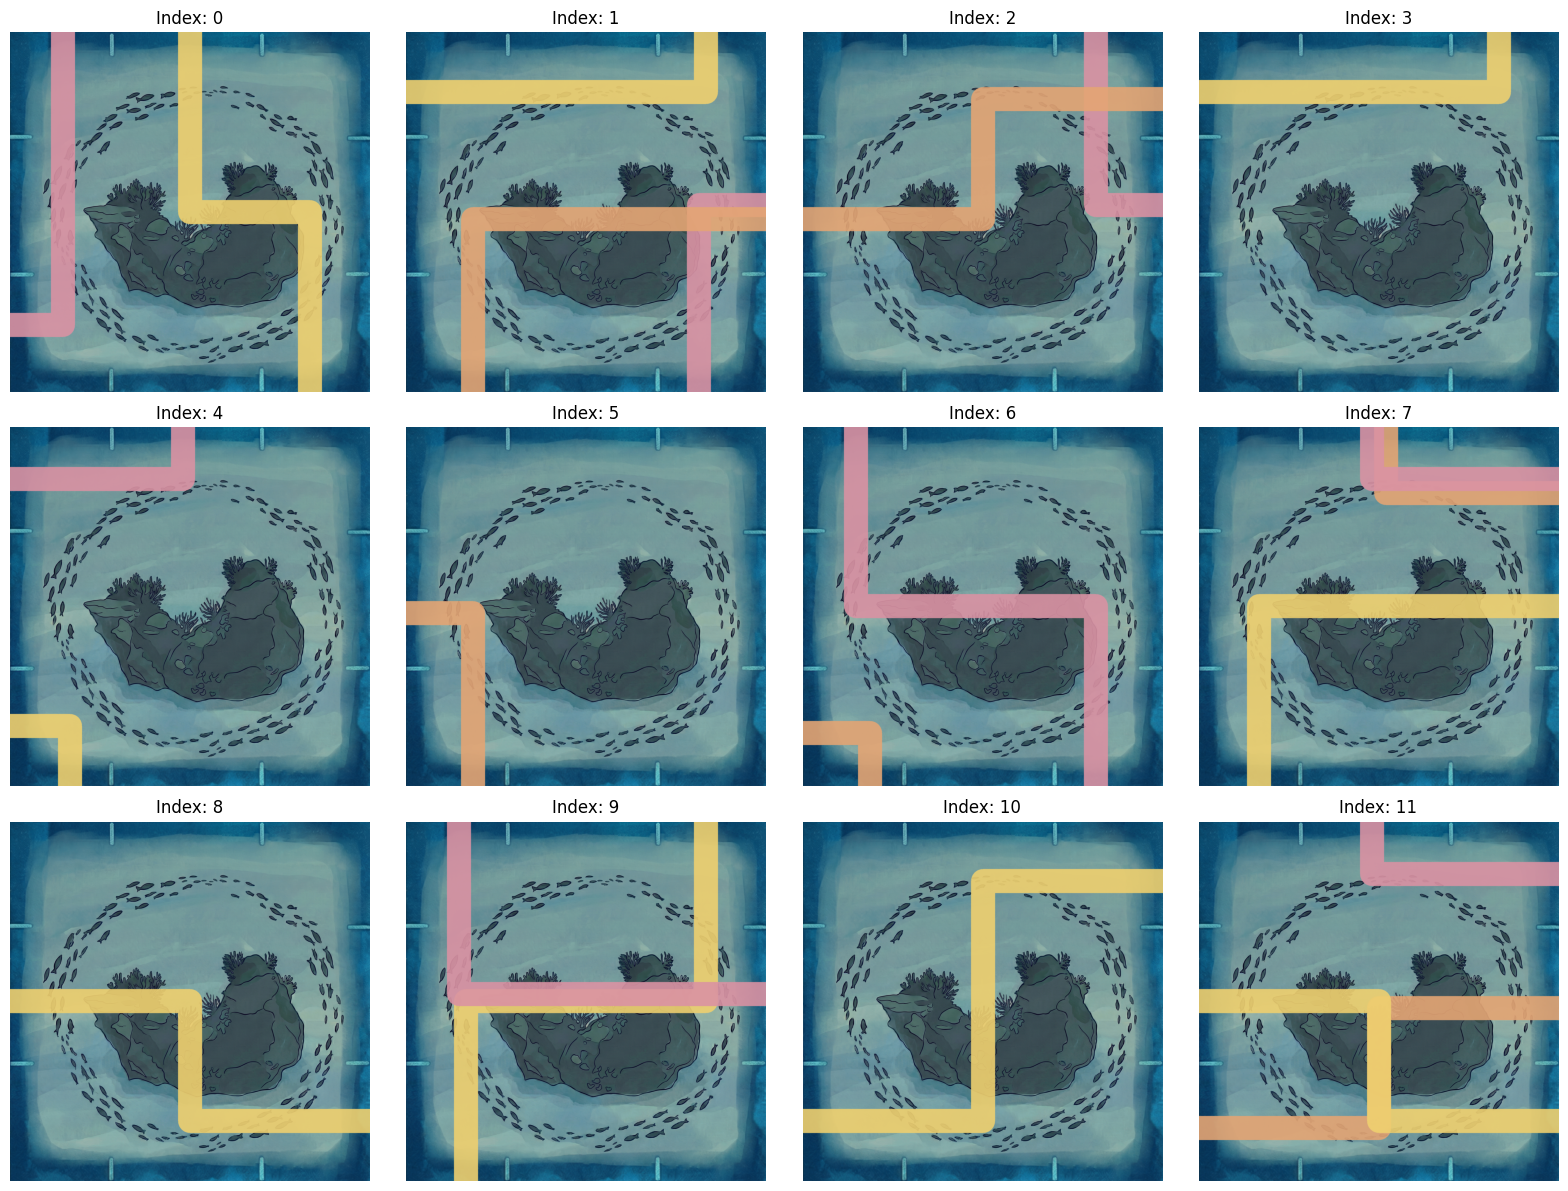

In [2]:
from typing import List, Tuple, Literal, Optional
from matplotlib import pyplot as plt
from PIL import Image as PILImage
import cv2
import numpy as np
from enum import Enum
from dataclasses import dataclass
import random


segment_count = 3

@dataclass
class RGB:
    r: int
    g: int
    b: int


class Level(Enum):
    pink = RGB(r=218, g=146, b=163)
    yellow = RGB(r=239, g=208, b=111)
    orange = RGB(r=228, g=165, b=116)


# Pre-compute level indices for offset calculation
LEVEL_INDEX = {level: i for i, level in enumerate(Level)}
LEVEL_COUNT = len(Level)


class Edge(Enum):
    left = 'left'
    top = 'top'
    right = 'right'
    bottom = 'bottom'


# Edge ordering for smooth path drawing
EDGE_ORDER = {
    Edge.left: 0,
    Edge.top: 1,
    Edge.bottom: 2,
    Edge.right: 3
}


@dataclass
class SegmentPoint:
    edge: Edge
    index: Literal[0, 1, 2]

    def __hash__(self):
      return hash((self.edge.name, self.index))


@dataclass
class PathConnection:
    start_segment: SegmentPoint
    end_segment: SegmentPoint
    level: Level

    def __repr__(self):
      return self.__str__()

    def __str__(self):
      return f"{self.start_segment.edge.value[0]}{self.start_segment.index} -> {self.end_segment.edge.value[0]}{self.end_segment.index} ({self.level.name})"


def segment_to_coord(seg: SegmentPoint, size: int, level: Optional[Level] = None, offset_pixels: int = 40) -> Tuple[int, int]:
    """Convert a SegmentPoint to (x, y) coordinates with optional level-based offset."""
    # Calculate segment center position (0.5, 1.5, 2.5, 3.5 out of X segments)
    pos = int((seg.index + 0.5) * size / segment_count)
    
    # Calculate offset based on level (centered around the segment position)
    if level is not None:
        level_idx = LEVEL_INDEX[level]
        # Center the offsets: offset = (index - (count-1)/2) * pixels
        offset = int((level_idx - (LEVEL_COUNT - 1) / 2) * offset_pixels)
    else:
        offset = 0
    
    # Apply offset perpendicular to the edge direction
    # For left/right edges: offset applies to Y (along the edge)
    # For top/bottom edges: offset applies to X (along the edge)
    coord_map = {
        Edge.left:   (0, pos + offset),
        Edge.right:  (size - 1, pos + offset),
        Edge.top:    (pos + offset, 0),
        Edge.bottom: (pos + offset, size - 1),
    }
    return coord_map[seg.edge]


def are_opposite(e1: Edge, e2: Edge) -> bool:
    """Check if two edges are opposite."""
    opposites = {
        Edge.left: Edge.right,
        Edge.right: Edge.left,
        Edge.top: Edge.bottom,
        Edge.bottom: Edge.top,
    }
    return opposites[e1] == e2


def normalize_path_direction(path_connection: PathConnection) -> PathConnection:
    """Normalize path direction to follow edge order: left, top, bottom, right."""
    start_order = EDGE_ORDER[path_connection.start_segment.edge]
    end_order = EDGE_ORDER[path_connection.end_segment.edge]
    
    # If start comes after end in the ordering, swap them
    if start_order > end_order:
        return PathConnection(
            start_segment=path_connection.end_segment,
            end_segment=path_connection.start_segment,
            level=path_connection.level
        )
    return path_connection


def draw_path(base_cv: np.ndarray, path_connection: PathConnection, color: RGB) -> np.ndarray:
    """Draw a path connecting two segment points on the image edges."""
    result = base_cv.copy()
    size = base_cv.shape[0]  # Assuming square image
    
    # Normalize path direction for consistent drawing
    path_connection = normalize_path_direction(path_connection)
    
    start = path_connection.start_segment
    end = path_connection.end_segment
    level = path_connection.level
    
    # Get endpoint coordinates with level-based offset
    p1 = segment_to_coord(start, size, level)
    p2 = segment_to_coord(end, size, level)
    
    # Determine path points based on edge relationship
    if are_opposite(start.edge, end.edge) and start.index == end.index:
        # I-shape: straight line
        points = [p1, p2]
    elif are_opposite(start.edge, end.edge):
        # N-shape: two turning points
        if start.edge in (Edge.left, Edge.right):
            # Vertical edges: mid points at center X, keeping Y from endpoints
            mid1 = (size // 2, p1[1])
            mid2 = (size // 2, p2[1])
        else:
            # Horizontal edges: mid points at center Y, keeping X from endpoints
            mid1 = (p1[0], size // 2)
            mid2 = (p2[0], size // 2)
        points = [p1, mid1, mid2, p2]
    else:
        # L-shape: one turning point at intersection
        if start.edge in (Edge.left, Edge.right):
            # Start is on vertical edge, end is on horizontal
            turn = (p2[0], p1[1])
        else:
            # Start is on horizontal edge, end is on vertical
            turn = (p1[0], p2[1])
        points = [p1, turn, p2]
    
    # Draw the path with opacity
    overlay = result.copy()
    cv_color = (color.b, color.g, color.r)  # OpenCV uses BGR
    thickness = max(2, size // 15)
    
    for i in range(len(points) - 1):
        cv2.line(overlay, points[i], points[i + 1], cv_color, thickness)
    
    # Blend with opacity
    alpha = 0.9
    result = cv2.addWeighted(overlay, alpha, result, 1 - alpha, 0)
    
    return result


def draw_all_paths(base: PILImage.Image, path_connections: List[PathConnection]) -> PILImage.Image:
    base_cv = cv2.cvtColor(np.array(base), cv2.COLOR_RGB2BGR)
    
    # Sort paths by edge order for smooth drawing
    sorted_paths = sorted(
        path_connections,
        key=lambda p: (
            EDGE_ORDER[p.start_segment.edge],
            EDGE_ORDER[p.end_segment.edge]
        )
    )
    
    for path_connection in sorted_paths:
        base_cv = draw_path(base_cv, path_connection, path_connection.level.value)
    return PILImage.fromarray(cv2.cvtColor(base_cv, cv2.COLOR_BGR2RGB))


def generate_random_paths(segment_count: int, max_paths: int = 3) -> List[PathConnection]:
    """Generate random path connections."""
    remain_num_paths = random.randint(1, max_paths)
    paths = []
    edges = list(Edge)
    levels = list(Level)
    used_levels = set()
    
    while remain_num_paths > 0:
        start_edge = random.choice(edges)
        available_end_edges = [e for e in edges if e != start_edge]
        end_edge = random.choice(available_end_edges)

        if start_edge == end_edge:
            continue
        
        start_index = random.randint(0, segment_count - 1)
        end_index = random.randint(0, segment_count - 1)
        if start_index == end_index:
            continue
        
        available_levels = [l for l in levels if l not in used_levels]
        if not available_levels:
            break
        level = random.choice(available_levels)
        used_levels.add(level)
        
        path = PathConnection(
            start_segment=SegmentPoint(edge=start_edge, index=start_index),
            end_segment=SegmentPoint(edge=end_edge, index=end_index),
            level=level
        )
        paths.append(path)
        remain_num_paths -= 1
    
    return paths

# Generate and draw 12 random path tiles
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(12):
    random_paths = generate_random_paths(segment_count=segment_count, max_paths=3)
    base_image = PILImage.open(current_path / 'src/assets/path-tile-background.jpeg')
    path_overlay_image = draw_all_paths(base_image, random_paths)
    print("Index:", i, "-", random_paths)
    
    axes[i].imshow(path_overlay_image)
    axes[i].set_title(f"Index: {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


1-path tiles: 27
2-path tiles: 132
3-path tiles: 84

TOTAL TILES: 243

=== Generating Tile Images ===

Generating 1-path tiles...


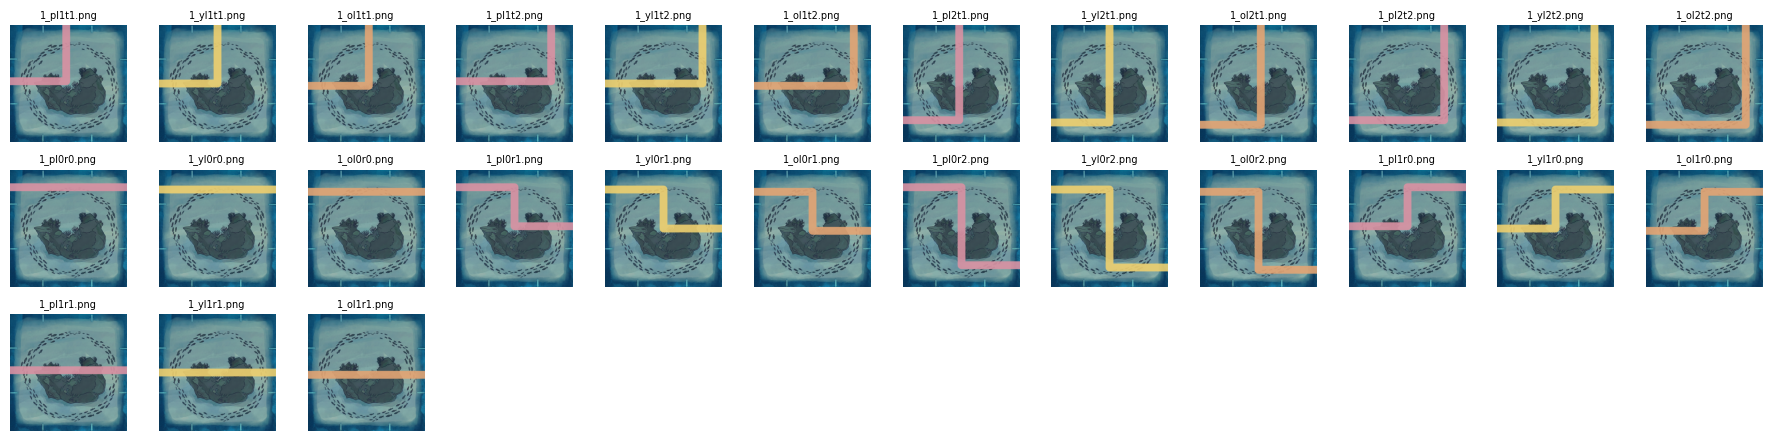

Saved 27 1-path tiles to /Users/chenj/Projects/ocean-relic/src/assets/path-tiles

Generating 2-path tiles...


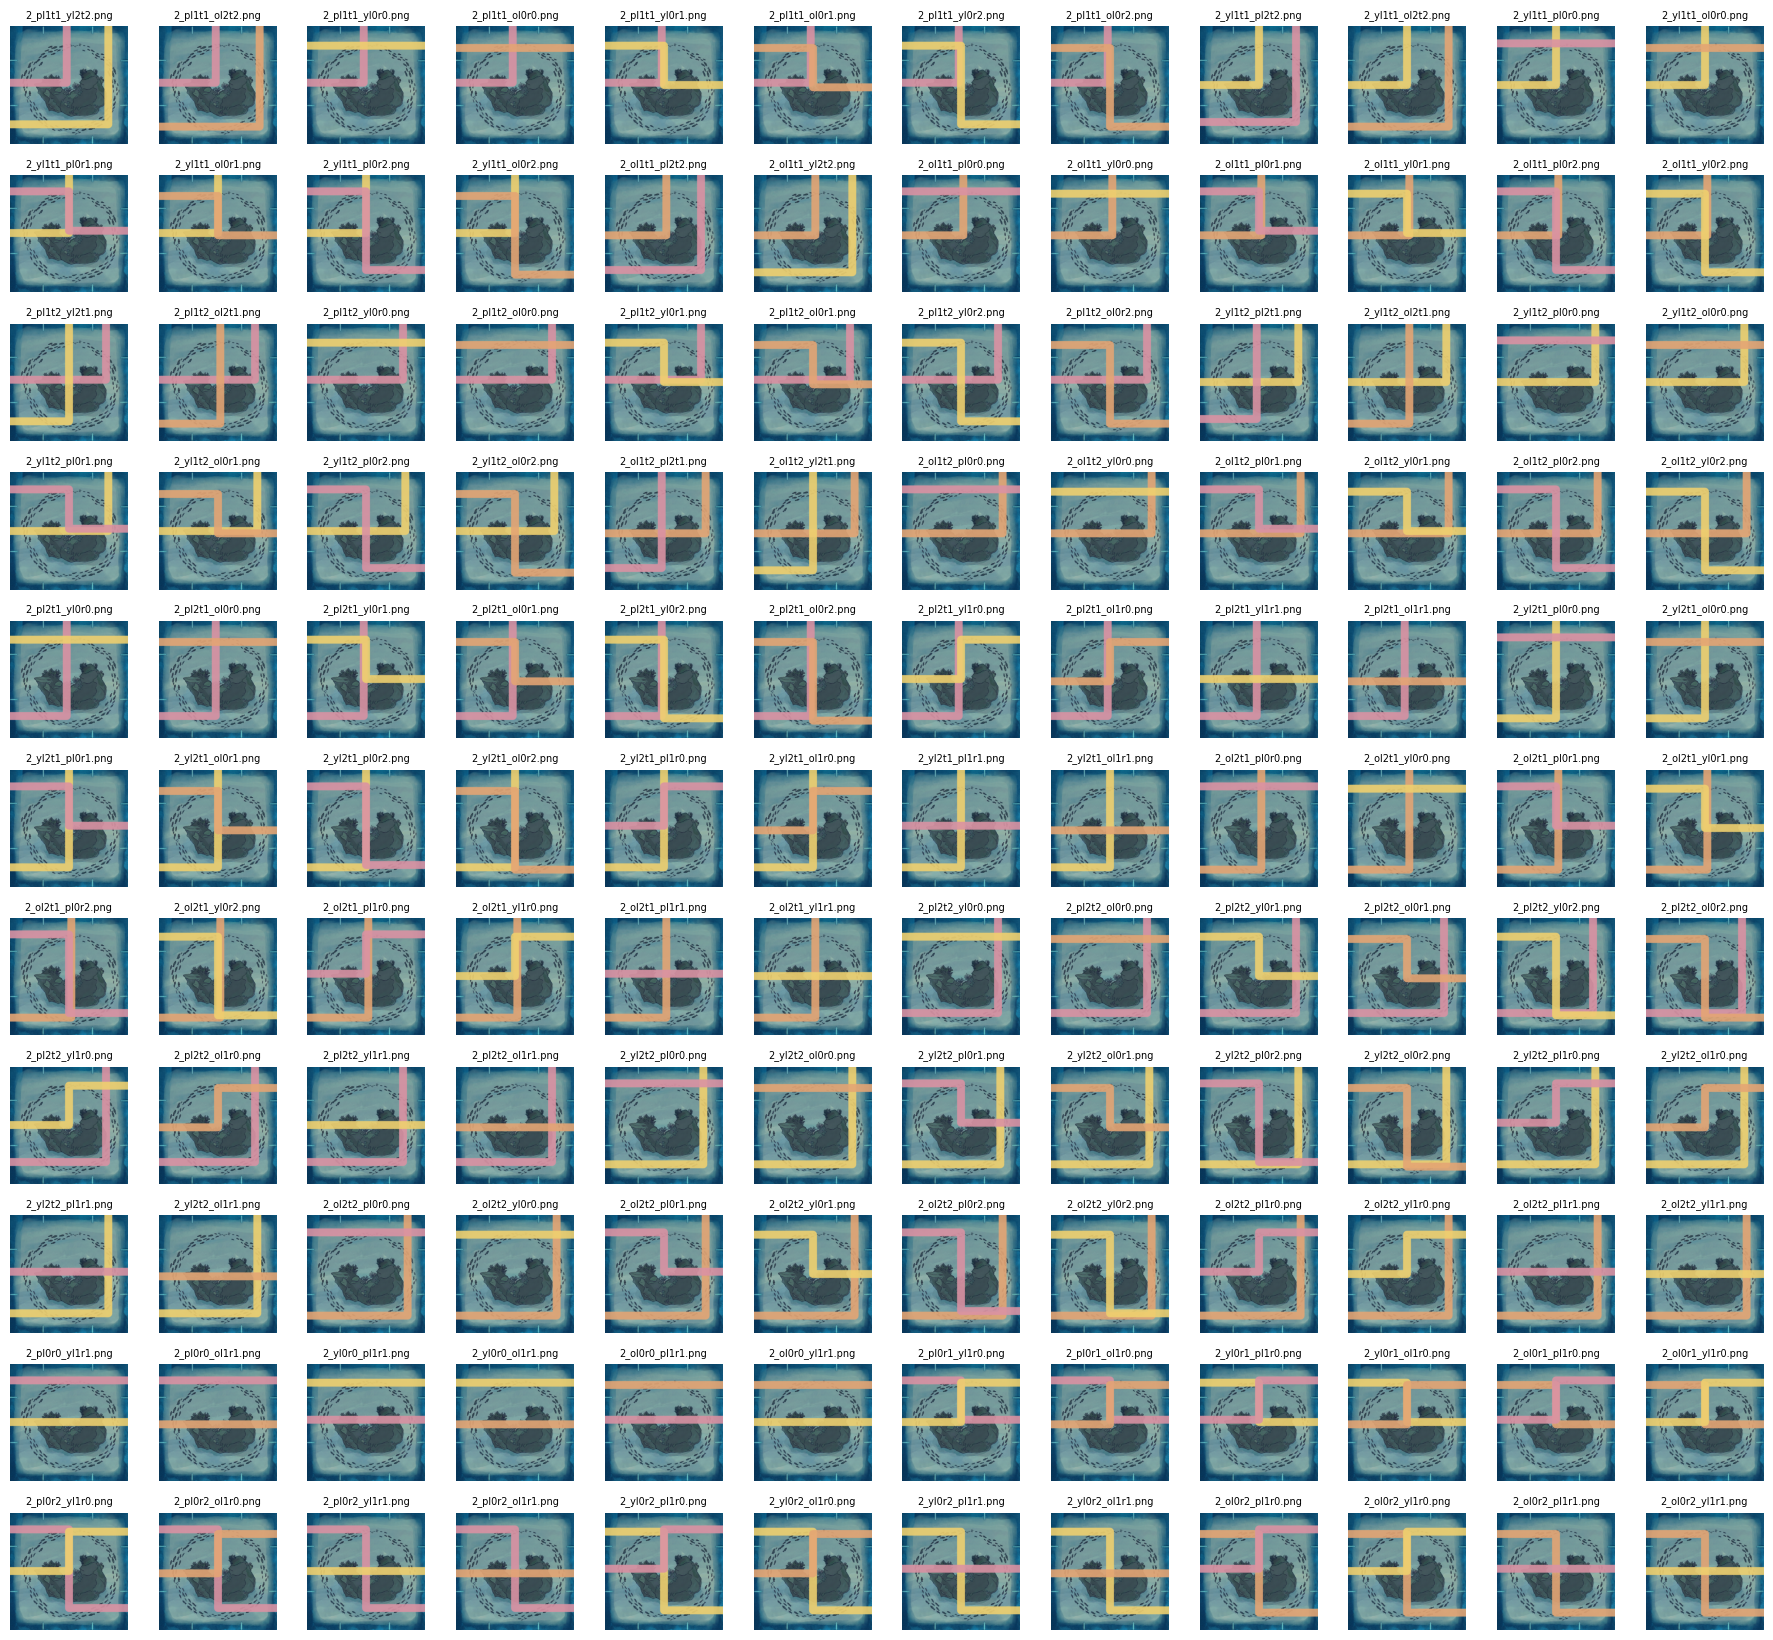

Saved 132 2-path tiles to /Users/chenj/Projects/ocean-relic/src/assets/path-tiles

Generating 3-path tiles...


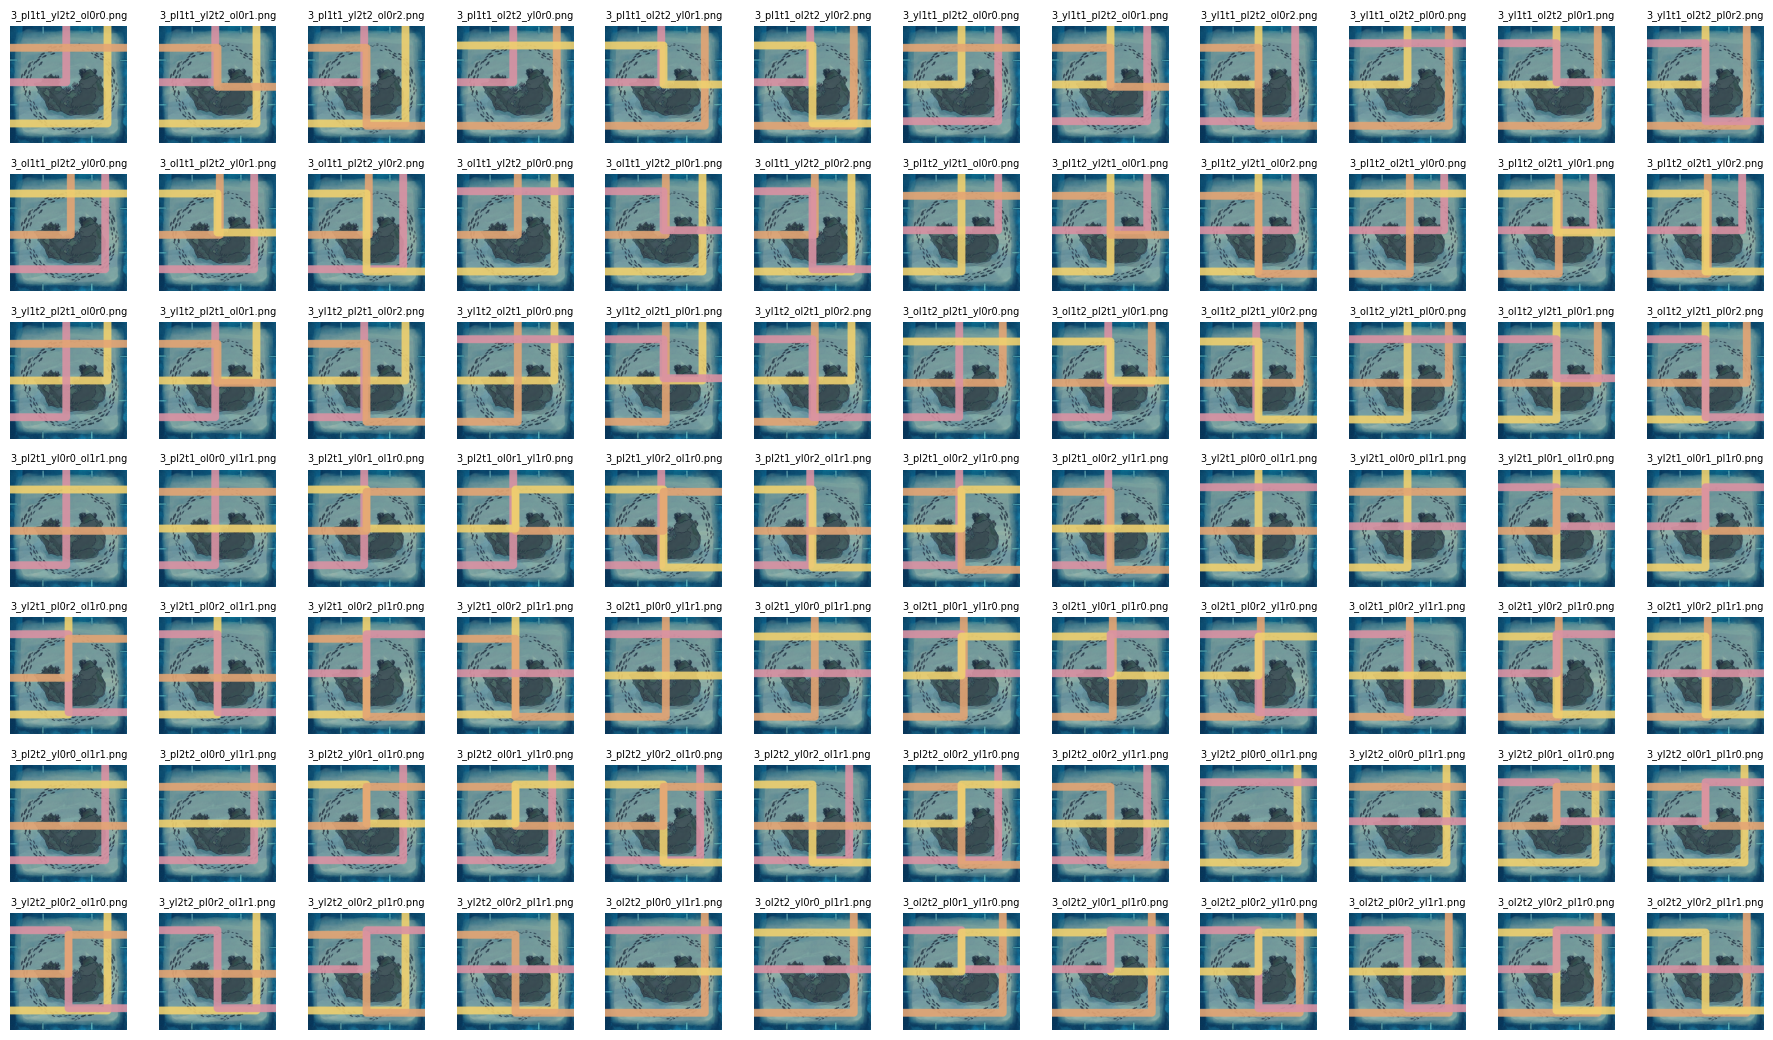

Saved 84 3-path tiles to /Users/chenj/Projects/ocean-relic/src/assets/path-tiles

=== All tiles generated and saved ===


In [5]:
from dataclasses import dataclass
from enum import Enum
from typing import List, Literal, Tuple, Set, FrozenSet
from itertools import combinations
import matplotlib.pyplot as plt
import os



def is_corner_connection(start: SegmentPoint, end_edge: Edge) -> bool:
    """Check if this is a corner connection (should be excluded).
    
    Corner connection: start segment is at the corner adjacent to the end edge.
    """
    max_idx = segment_count - 1
    
    corner_adjacency = {
        (Edge.left, 0): {Edge.top},
        (Edge.left, max_idx): {Edge.bottom},
        (Edge.top, 0): {Edge.left},
        (Edge.top, max_idx): {Edge.right},
        (Edge.right, 0): {Edge.top},
        (Edge.right, max_idx): {Edge.bottom},
        (Edge.bottom, 0): {Edge.left},
        (Edge.bottom, max_idx): {Edge.right},
    }
    
    adjacent_edges = corner_adjacency.get((start.edge, start.index), set())
    return end_edge in adjacent_edges


def connections_share_segment_points(connections: List[PathConnection]) -> bool:
    """Check if any two connections share any segment point."""
    all_points = set()
    for connection in connections:
        shape_points = {connection.start_segment, connection.end_segment}
        if all_points & shape_points:  # Check for intersection
            return True
        all_points.update(shape_points)
    return False


# === Path Shape Generation ===

def generate_single_path_tiles() -> List[PathConnection]:
    """Generate all unique single path shapes with exclusions.
    
    Exclusions:
    1. Corner connections: segment at corner cannot connect to adjacent edge
    2. Straight lines: opposite edges with same segment index
    
    Canonical forms:
    - Left -> Top: direction equivalence (L[i]->T[j] ≡ T[j]->L[i])
    - Left -> Right: 180° rotation equivalence (L[i]->R[j] ≡ L[max-i]->R[max-j])
    """
    paths = []
    max_idx = segment_count - 1
    
    # === Left -> Top (L-shape, adjacent edges) ===
    for si in range(segment_count):
        for ei in range(segment_count):
            start = SegmentPoint(Edge.left, si)
            end = SegmentPoint(Edge.top, ei)
            
            # Check corner exclusion from both directions
            if is_corner_connection(start, Edge.top):
                continue
            if is_corner_connection(end, Edge.left):
                continue
            
            for level in Level:
                paths.append(PathConnection(start, end, level))
    
    # === Left -> Right (I/N-shape, opposite edges) ===
    seen = set()
    for si in range(segment_count):
        for ei in range(segment_count):
            start = SegmentPoint(Edge.left, si)
            end = SegmentPoint(Edge.right, ei)
            
            # 180° rotation deduplication
            equiv = (max_idx - si, max_idx - ei)
            canonical = min((si, ei), equiv)
            
            if canonical in seen:
                continue
            
            seen.add(canonical)
            for level in Level:
                paths.append(PathConnection(start, end, level))
    
    return paths



def generate_two_path_tiles(connections: List[PathConnection]) -> List[List[PathConnection]]:
    """Generate all 2-path tiles."""
    tiles = []
    levels = list(Level)
    
    for s1, s2 in combinations(connections, 2):
        if s1.level == s2.level:
            continue
        if connections_share_segment_points([s1, s2]):
            continue
        
        tiles.append([s1, s2])
    
    return tiles


def generate_three_path_tiles(connections: List[PathConnection]) -> List[List[PathConnection]]:
    """Generate all 3-path tiles."""
    tiles = []
    levels = list(Level)
    
    for s1, s2, s3 in combinations(connections, 3):
        if len(set([s1.level, s2.level, s3.level])) != 3:
            continue
        if connections_share_segment_points([s1, s2, s3]):
            continue
        
        tiles.append([s1, s2, s3])
    
    return tiles


# === Run Generation ===
one_path_tiles = generate_single_path_tiles()
two_path_tiles = generate_two_path_tiles(one_path_tiles)
three_path_tiles = generate_three_path_tiles(one_path_tiles)

print(f"1-path tiles: {len(one_path_tiles)}")
print(f"2-path tiles: {len(two_path_tiles)}")
print(f"3-path tiles: {len(three_path_tiles)}")
print(f"\nTOTAL TILES: {len(one_path_tiles) + len(two_path_tiles) + len(three_path_tiles)}")

# === Generate and Save Tile Images ===

# Create output directory
output_dir = current_path / 'src/assets/path-tiles'
os.makedirs(output_dir, exist_ok=True)

def generate_tile_filename(tile_paths: List[PathConnection]) -> str:
    """Generate filename from path connections."""
    # Ensure tile_paths is a list
    if not isinstance(tile_paths, list):
        tile_paths = [tile_paths]
    
    # Start with number of paths
    num_paths = len(tile_paths)
    filename_parts = [str(num_paths)]
    
    # Add each path's info: level + left segment + right segment
    for path in tile_paths:
        level_prefix = path.level.name[0]
        start_seg_edge = path.start_segment.edge.value[0]
        end_seg_edge = path.end_segment.edge.value[0]
        path_part = f"{level_prefix}{start_seg_edge}{path.start_segment.index}{end_seg_edge}{path.end_segment.index}"
        filename_parts.append(path_part)
    
    return "_".join(filename_parts) + ".png"

def generate_and_save_tiles(tiles: List[List[PathConnection]] | List[PathConnection], prefix: str):
    """Generate images for tiles and save them."""
    num_tiles = len(tiles)
    
    # Calculate grid dimensions
    cols = min(12, num_tiles)
    rows = (num_tiles + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    if num_tiles == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else axes
    
    for i, tile_paths in enumerate(tiles):
        base_image = PILImage.open(current_path / 'src/assets/path-tile-background.jpeg')
        if isinstance(tile_paths, list):
            path_overlay_image = draw_all_paths(base_image, tile_paths)
        else:
            path_overlay_image = draw_all_paths(base_image, [tile_paths])
        
        # Resize to 512x512
        path_overlay_image = path_overlay_image.resize((512, 512), PILImage.Resampling.LANCZOS)
        
        # Generate filename based on path info
        tile_filename = generate_tile_filename(tile_paths)
        path_overlay_image.save(output_dir / tile_filename, format='PNG')
        
        # Display in grid
        axes[i].imshow(path_overlay_image)
        axes[i].set_title(f"{tile_filename}", fontsize=7)
        axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Saved {num_tiles} {prefix} tiles to {output_dir}")

print("\n=== Generating Tile Images ===\n")

print("Generating 1-path tiles...")
generate_and_save_tiles(one_path_tiles, "1-path")

print("\nGenerating 2-path tiles...")
generate_and_save_tiles(two_path_tiles, "2-path")

print("\nGenerating 3-path tiles...")
generate_and_save_tiles(three_path_tiles, "3-path")

print("\n=== All tiles generated and saved ===")